In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Load the Data
First, we'll load the insurance dataset and inspect the first few rows.

In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Insurance fraud detection/dataset/insurance_data.csv')
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


The dataset contains 40 columns, including various details about insurance policies, claims, and whether fraud was reported. Let's proceed with the data preparation steps.

# Initial Data Exploration

We'll check for missing values, understand the data types, and summarize the numerical and categorical features.

In [4]:
# Check for missing values
missing_values = df.isnull().sum()

# Understand data types
data_types = df.dtypes

# Summarize numerical features
numerical_summary = df.describe()

# Summarize categorical features
categorical_summary = df.describe(include=['object'])

missing_values, data_types, numerical_summary, categorical_summary

(months_as_customer                0
 age                               0
 policy_number                     0
 policy_bind_date                  0
 policy_state                      0
 policy_csl                        0
 policy_deductable                 0
 policy_annual_premium             0
 umbrella_limit                    0
 insured_zip                       0
 insured_sex                       0
 insured_education_level           0
 insured_occupation                0
 insured_hobbies                   0
 insured_relationship              0
 capital-gains                     0
 capital-loss                      0
 incident_date                     0
 incident_type                     0
 collision_type                    0
 incident_severity                 0
 authorities_contacted            91
 incident_state                    0
 incident_city                     0
 incident_location                 0
 incident_hour_of_the_day          0
 number_of_vehicles_involved       0
 

## Summary of Initial Data Exploration
### 1. Missing Values:

* Column _c39 has 1000 missing values, implying it's entirely empty and can be dropped.
* Columns authorities_contacted, police_report_available and property_damage have entries marked as ?, indicating potential missing values or incorrect encoding.

### 2. Data Types:

The dataset contains a mix of integers, floats, and objects (categorical data).

### 3. Categorical Features:

Various categorical features with differing unique values.
Notably insured_occupation, and auto_model have many unique entries.

# Handling Missing Values

We'll handle missing values and clean the dataset. We can create new categories for the missing data.

In [5]:
df.drop('_c39',axis=1,inplace=True)
df['police_report_available'].replace('?', 'Unknown', inplace=True)
df['property_damage'].replace('?', 'Unknown', inplace=True)
df['authorities_contacted'].replace(pd.NA, 'None',inplace=True)

missing_values_after_cleaning = df.isnull().sum()

missing_values_after_cleaning

months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_rep

# Feature Engineering

Create new features if necessary and drop irrelevant features.

## Correlation Analysis

Analyze correlations to handle multicollinearity.

<Axes: >

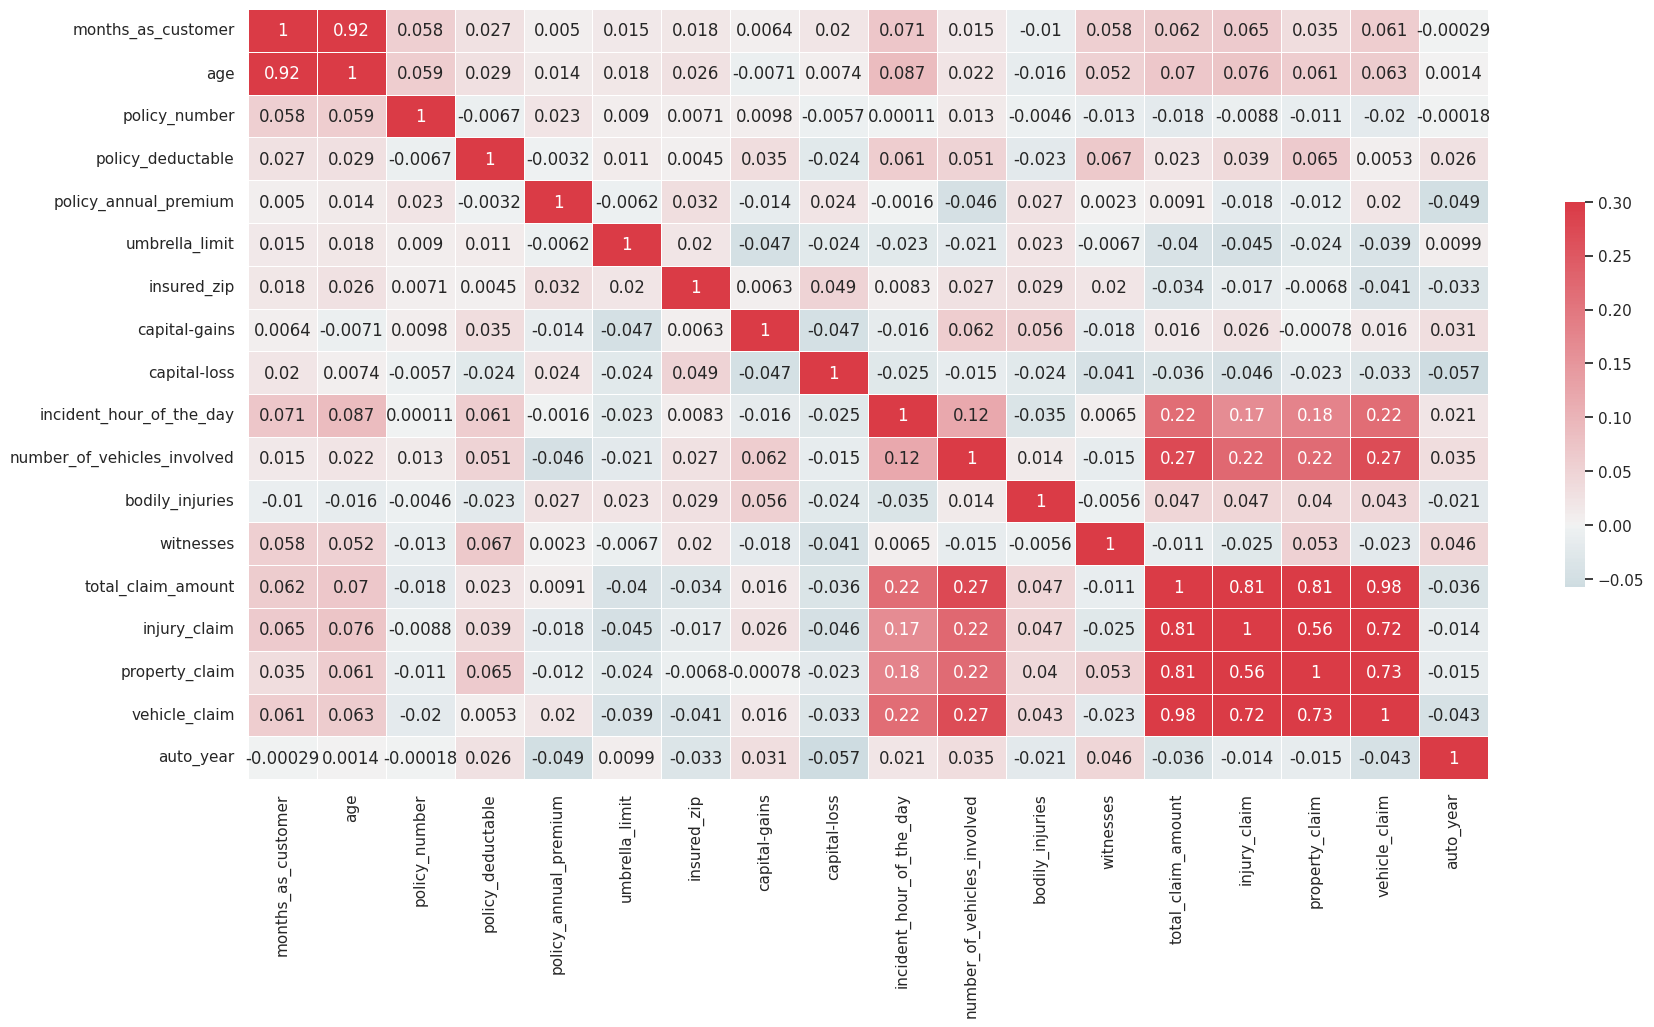

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(df.corr(numeric_only=True), cmap=cmap, vmax=.3, center=0,annot=True, square=False, linewidths=.5, cbar_kws={"shrink": .5})

In [9]:
df.select_dtypes(include = 'object').nunique(axis=0).sort_values(ascending=False)

incident_location          1000
policy_bind_date            951
incident_date                60
auto_model                   39
insured_hobbies              20
auto_make                    14
insured_occupation           14
insured_education_level       7
incident_city                 7
incident_state                7
insured_relationship          6
authorities_contacted         5
collision_type                4
incident_severity             4
incident_type                 4
policy_state                  3
property_damage               3
police_report_available       3
policy_csl                    3
insured_sex                   2
fraud_reported                2
dtype: int64

Dropping columns based on above result.

In [10]:
df.drop(['incident_location','policy_bind_date','incident_date','auto_model','insured_occupation','policy_number'], axis=1, inplace=True)

Plot insured_hobbies against fraud_reported to find the dominating categories.

<Axes: xlabel='insured_hobbies', ylabel='count'>

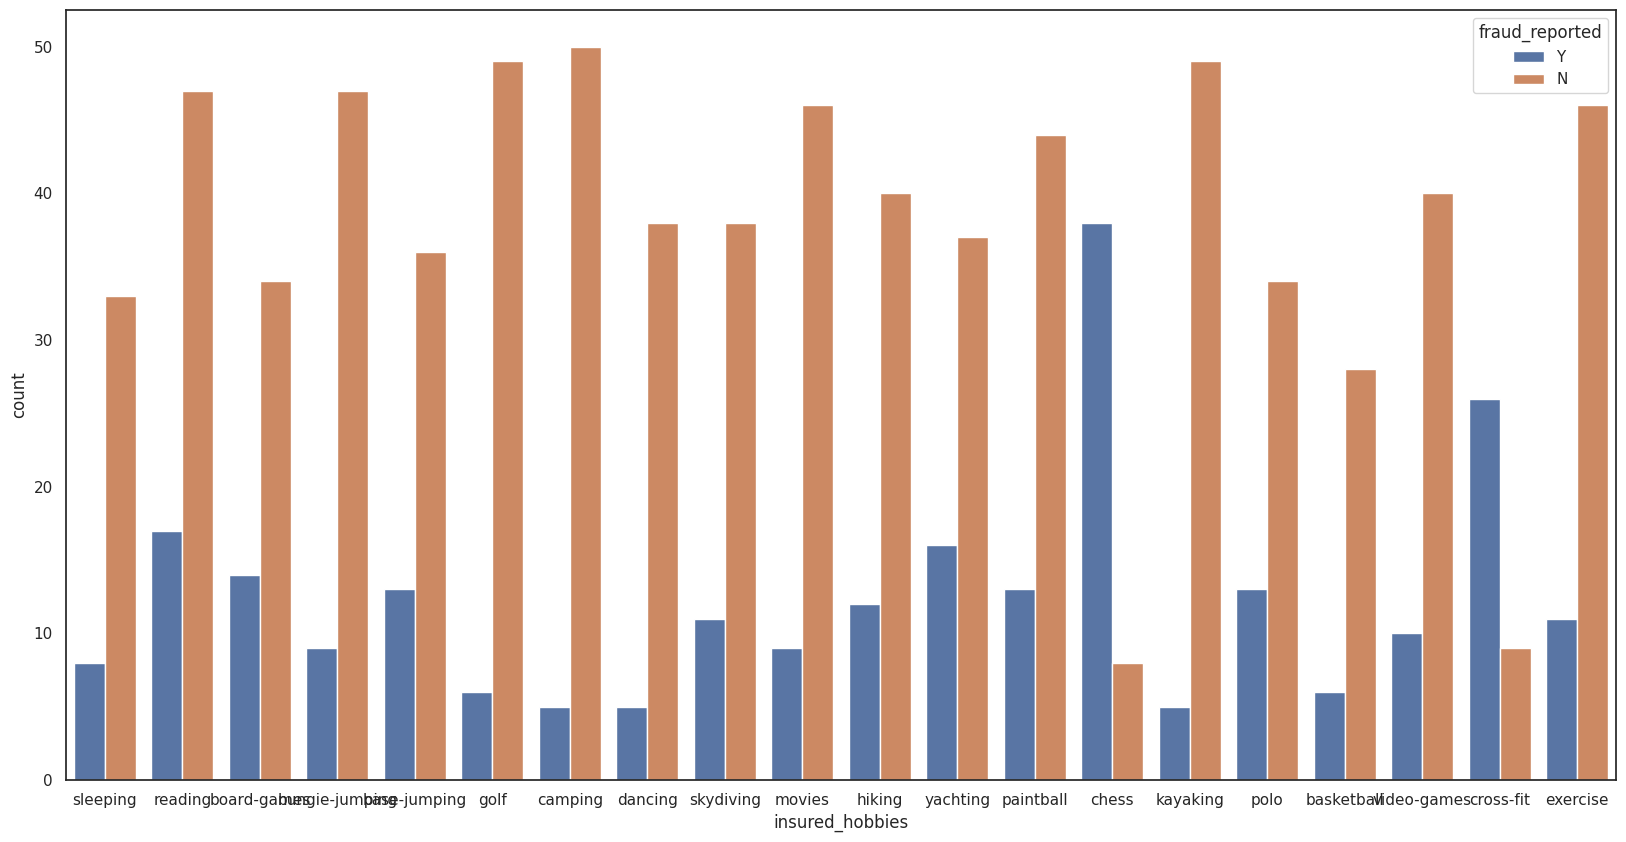

In [11]:

plt.subplots(figsize=(20, 10))
sns.countplot(x='insured_hobbies',hue='fraud_reported',data=df)

Create additional 'other' column if insured_hobbies are not chess and cross fit.

In [12]:
df['insured_hobbies']=df['insured_hobbies'].apply(lambda x :'other' if x!='chess' and x!='cross-fit' else x)
df['insured_hobbies'].unique()

array(['other', 'chess', 'cross-fit'], dtype=object)

# Check for Class imbalance

Looking at the graph below, we can see the classes are mildly imbalanced.


<Axes: xlabel='fraud_reported', ylabel='count'>

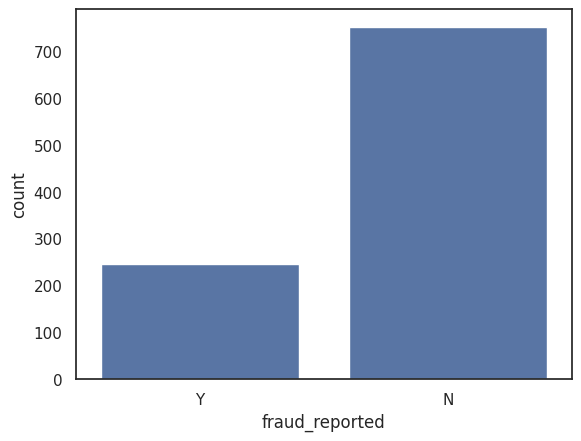

In [13]:
sns.countplot(x='fraud_reported',data=df)

## Encoding Categorical Values

Convert categorical variables(responses) into numerical data using Label Binarizer.

In [14]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

df['fraud_reported'] = lb.fit_transform(df['fraud_reported'])

Convert categorical variables(features) into numerical data using One Hot Encoding.

In [15]:
df = pd.get_dummies(df)
print(df.shape)

(1000, 93)


# Export prepared data

In [16]:
df.to_csv('/content/drive/MyDrive/Insurance fraud detection/dataset/insurance_data_prepared.csv', index=False)